<a href="https://colab.research.google.com/github/Manu-Sanchez/Learning/blob/ai%2Fbasic-gan/CNN_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
train_data = datasets.FashionMNIST(root="../data", train=1, download=1, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST(root="../data", train=0, download=1, transform=transforms.ToTensor())

100%|██████████| 26421880/26421880 [00:03<00:00, 7740012.40it/s] 


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 134087.58it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2547950.86it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16751184.63it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [6]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [35]:
class_names = ["T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

label: 9
torch.Size([1, 28, 28])


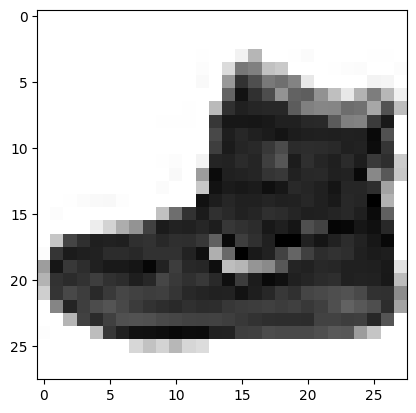

In [15]:
image, label = train_data[0]
print("label:", label)
print(image.shape)
plt.imshow(image.permute(1,2,0), cmap="gist_yarg")

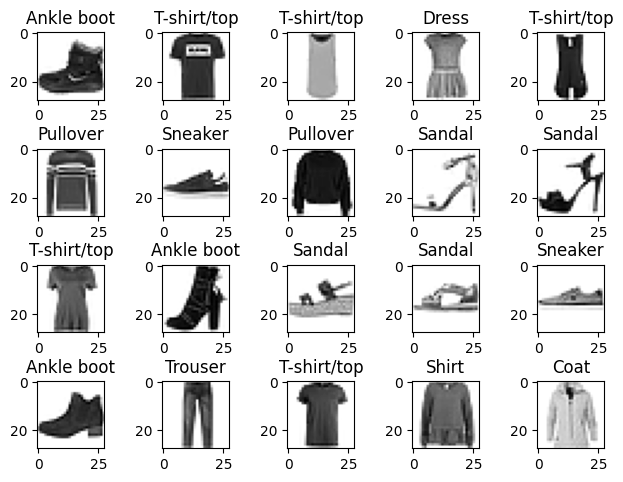

In [38]:

nItems = 20
nRows = 4

nItems_per_row = nItems//nRows

fig, axes = plt.subplots(nRows, nItems_per_row)
fig.tight_layout()

for idx, ax in enumerate(axes.flatten()):
  img, label = train_data[idx]

  ax.set_title(f"{class_names[label]}")
  ax.imshow(img.permute(1,2,0), cmap="gist_yarg")


In [46]:
train_data_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=250, shuffle=False)

In [43]:
conv1 = nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

img, label = train_data[0]
print(f"Initial shape: {img.shape}")
img = F.relu(conv1(img))
print(f"First Convolutional Layer: {img.shape}")
img = F.max_pool2d(img, 2, 2)
print(f"Ater first pooling: {img.shape}")
img = F.relu(conv2(img))
print(f"Second Convolutional Layer: {img.shape}")
img = F.max_pool2d(img, 2, 2)
print(f"Ater second pooling: {img.shape}")

Initial shape: torch.Size([1, 28, 28])
First Convolutional Layer: torch.Size([6, 26, 26])
Ater first pooling: torch.Size([6, 13, 13])
Second Convolutional Layer: torch.Size([16, 11, 11])
Ater second pooling: torch.Size([16, 5, 5])


In [60]:
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
    self.conv2 = nn.Conv2d(6, 16, 3, 1)
    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, len(class_names))

  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.reshape(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return F.log_softmax(x, dim=1)

In [61]:
model = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [49]:
for param in model.parameters():
  print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [62]:
epochs = 5

train_loss = []
test_loss = []

train_hits = []
test_hits = []

for epoch in range(epochs):
  tr_hits = 0
  ts_hits = 0

  for batch_idx, (x_tr, y_tr) in enumerate(train_data_loader):

    batch_idx += 1

    y_pred = model(x_tr)
    loss = criterion(y_pred, y_tr)

    optim.zero_grad()
    loss.backward()
    optim.step()

    tr_hits += (torch.max(y_pred, 1)[1] == y_tr).sum()
    if batch_idx%100 == 0:
      print(f"Epoch {epoch:4.0f} Batch {batch_idx:4.0f} Loss {loss:4.2f} Hits {tr_hits:4.0f} Accuracy {tr_hits/batch_idx:4.2f}%")


  train_loss.append(loss)
  train_hits.append(tr_hits)

  with torch.no_grad():

    for batch_idx, (x_ts, y_ts) in enumerate(test_data_loader):

      y_pred = model(x_ts)
      ts_hits += (torch.max(y_pred, 1)[1] == y_ts).sum()


  loss = criterion(y_pred, y_ts)
  test_loss.append(loss)
  test_hits.append(ts_hits)


Epoch    0 Batch  100 Loss 0.90 Hits 5453 Accuracy 54.53%
Epoch    0 Batch  200 Loss 0.96 Hits 12478 Accuracy 62.39%
Epoch    0 Batch  300 Loss 0.56 Hits 20016 Accuracy 66.72%
Epoch    0 Batch  400 Loss 0.62 Hits 27810 Accuracy 69.53%
Epoch    0 Batch  500 Loss 0.55 Hits 35713 Accuracy 71.43%
Epoch    0 Batch  600 Loss 0.53 Hits 43783 Accuracy 72.97%
Epoch    1 Batch  100 Loss 0.52 Hits 8101 Accuracy 81.01%
Epoch    1 Batch  200 Loss 0.45 Hits 16282 Accuracy 81.41%
Epoch    1 Batch  300 Loss 0.63 Hits 24586 Accuracy 81.95%
Epoch    1 Batch  400 Loss 0.50 Hits 32954 Accuracy 82.39%
Epoch    1 Batch  500 Loss 0.41 Hits 41340 Accuracy 82.68%
Epoch    1 Batch  600 Loss 0.55 Hits 49728 Accuracy 82.88%
Epoch    2 Batch  100 Loss 0.46 Hits 8451 Accuracy 84.51%
Epoch    2 Batch  200 Loss 0.35 Hits 16894 Accuracy 84.47%
Epoch    2 Batch  300 Loss 0.32 Hits 25430 Accuracy 84.77%
Epoch    2 Batch  400 Loss 0.39 Hits 33955 Accuracy 84.89%
Epoch    2 Batch  500 Loss 0.32 Hits 42521 Accuracy 85.04%


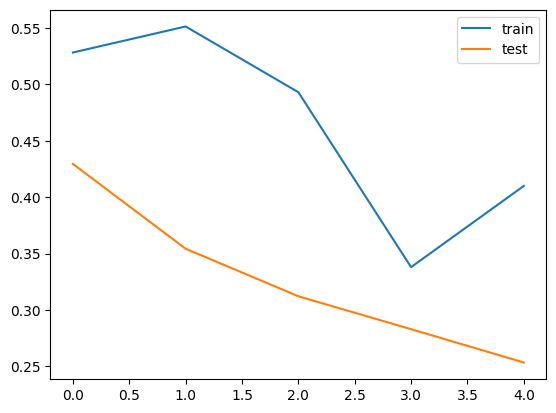

In [65]:
plt.plot([loss.data.numpy() for loss in train_loss], label="train")
plt.plot([loss.data.numpy() for loss in test_loss], label="test")
plt.legend()
plt.show()

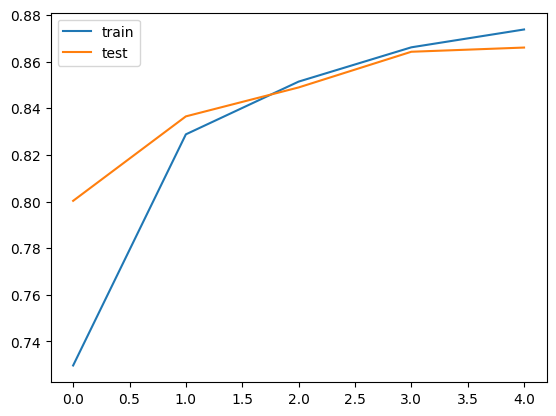

In [67]:
plt.plot([hit/60000 for hit in train_hits], label="train")
plt.plot([hit/10000 for hit in test_hits], label="test")
plt.legend()
plt.show()

In [57]:
print(f"hola{8:6.0f}mundo")

hola     8mundo
